# Predict the Introverts from the Extroverts
This project aims to predict an individual's personality type (Extrovert or Introvert) based on various behavioral and social attributes. The solution utilizes a machine learning pipeline involving data preprocessing, exploratory data analysis, model training with an ensemble of gradient boosting algorithms (XGBoost, CatBoost, LightGBM, HistGradientBoostingClassifier), hyperparameter tuning with Optuna, and a user-friendly web interface built with Gradio.

**Key Technologies and Libraries Used:**
- Python
- Pandas for data manipulation
- Scikit-learn for machine learning utilities and base models
- XGBoost for gradient boosting
- CatBoost for gradient boosting
- LightGBM for gradient boosting
- HistGradientBoostingClassifier for gradient boosting
- Optuna for hyperparameter optimization
- Gradio for building the interactive web interface

## Data Loading and Preprocessing

This section details the initial steps taken to prepare the data for model training.

1.  **Data Loading**: The `train.csv` and `test.csv` datasets were loaded into pandas DataFrames, with the 'id' column set as the index.
2.  **Missing Value Imputation**:
    *   **Numerical Features**: Missing values in numerical columns (`Time_spent_Alone`, `Social_event_attendance`, `Going_outside`, `Friends_circle_size`, `Post_frequency`) were imputed using the **median** strategy via `SimpleImputer`.
    *   **Categorical Features**: Missing values in categorical columns (`Stage_fear`, `Drained_after_socializing`) were handled using `KNNImputer`. Before imputation, these features were mapped to numerical values (0 for 'No', 1 for 'Yes') to be compatible with KNN imputation. After imputation, the imputed float values were rounded and converted back to integers.
3.  **Target Variable Encoding**: The 'Personality' column in the training dataset was encoded to numerical values: 'Extrovert' was mapped to 0 and 'Introvert' was mapped to 1.

In [ ]:
pip install optuna catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.9 MB/s eta 0:00:00


In [ ]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import optuna

df = pd.read_csv("train.csv", index_col='id')
df_test = pd.read_csv("test.csv", index_col='id')
y = df['Personality']
df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 16631 non-null  object 
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  17375 non-null  object 
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
 7   Personality                18524 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.3+ MB


In [ ]:
df.isna().sum()

,0
Time_spent_Alone,1190
Stage_fear,1893
Social_event_attendance,1180
Going_outside,1466
Drained_after_socializing,1149
Friends_circle_size,1054
Post_frequency,1264
Personality,0


In [ ]:
from sklearn.impute import SimpleImputer, KNNImputer

df_imputed = df.copy()
numerical_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']

for col in numerical_cols:
  median_imputer = SimpleImputer(missing_values=np.nan, strategy="median")
  df_imputed[col] = median_imputer.fit_transform(df_imputed[[col]])

In [ ]:
categorical_cols = ['Stage_fear', 'Drained_after_socializing']

for col in categorical_cols:
  df_imputed[col] = df_imputed[col].map({"No": 0, "Yes": 1})
  knn_imputer = KNNImputer(n_neighbors=3, weights='uniform')
  df_imputed[col] = knn_imputer.fit_transform(df_imputed[[col]])

  print(f"\nNaNs in original {col}: {df[col].isna().sum()}")
  print(f"NaNs in imputed {col}: {df_imputed[col].isna().sum()}")


NaNs in original Stage_fear: 1893
NaNs in imputed Stage_fear: 0

NaNs in original Drained_after_socializing: 1149
NaNs in imputed Drained_after_socializing: 0


In [ ]:
def median_imputation(numerical_cols: list[str], df: pd.DataFrame):
  for col in numerical_cols:
    median_imputer = SimpleImputer(missing_values=np.nan, strategy="median")
    df[col] = median_imputer.fit_transform(df[[col]])
  return df

def knn_imputation(categorical_cols: list[str], df: pd.DataFrame):
  for col in categorical_cols:
    df[col] = df[col].map({"No": 0, "Yes": 1})
    knn_imputer = KNNImputer(n_neighbors=3, weights='uniform')
    df[col] = knn_imputer.fit_transform(df[[col]]).astype(int)
  return df

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6175 entries, 18524 to 24698
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           5750 non-null   float64
 1   Stage_fear                 5577 non-null   object 
 2   Social_event_attendance    5778 non-null   float64
 3   Going_outside              5709 non-null   float64
 4   Drained_after_socializing  5743 non-null   object 
 5   Friends_circle_size        5825 non-null   float64
 6   Post_frequency             5767 non-null   float64
dtypes: float64(5), object(2)
memory usage: 385.9+ KB


In [ ]:
df_test = median_imputation(['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency'], df_test)
df_test = knn_imputation(['Stage_fear', 'Drained_after_socializing'], df_test)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6175 entries, 18524 to 24698
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           6175 non-null   float64
 1   Stage_fear                 6175 non-null   int64  
 2   Social_event_attendance    6175 non-null   float64
 3   Going_outside              6175 non-null   float64
 4   Drained_after_socializing  6175 non-null   int64  
 5   Friends_circle_size        6175 non-null   float64
 6   Post_frequency             6175 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 385.9 KB


In [ ]:
df_imputed['Personality'] = df_imputed['Personality'].map({"Extrovert": 0, "Introvert": 1})
df_imputed.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,0.0,6.0,4.0,0.000000,15.0,5.0,0
1,1.0,0.0,7.0,3.0,0.000000,10.0,8.0,0
2,6.0,1.0,1.0,0.0,0.233784,3.0,0.0,1
3,3.0,0.0,7.0,3.0,0.000000,11.0,5.0,0
4,1.0,0.0,4.0,4.0,0.000000,13.0,5.0,0


## Exploratory Data Analysis (EDA)

This section focuses on understanding the relationships within the data and with the target variable.

1.  **Correlation Heatmap**: A correlation heatmap was generated to visualize the linear relationships between the numerical features in the imputed dataset (`df_imputed`). This helps identify highly correlated features.
2.  **Mutual Information Analysis**: Mutual information was calculated between each feature and the 'Personality' target variable. This technique measures the dependency between variables and is useful for understanding feature importance, especially for non-linear relationships. The results were sorted to show the most informative features first.
3.  **Categorical Feature Visualizations**: Count plots were created to visualize the distribution of 'Personality' (Extrovert/Introvert) against key categorical features: 'Drained_after_socializing' and 'Stage_fear'. These plots help in understanding how different categories of these features relate to personality types.

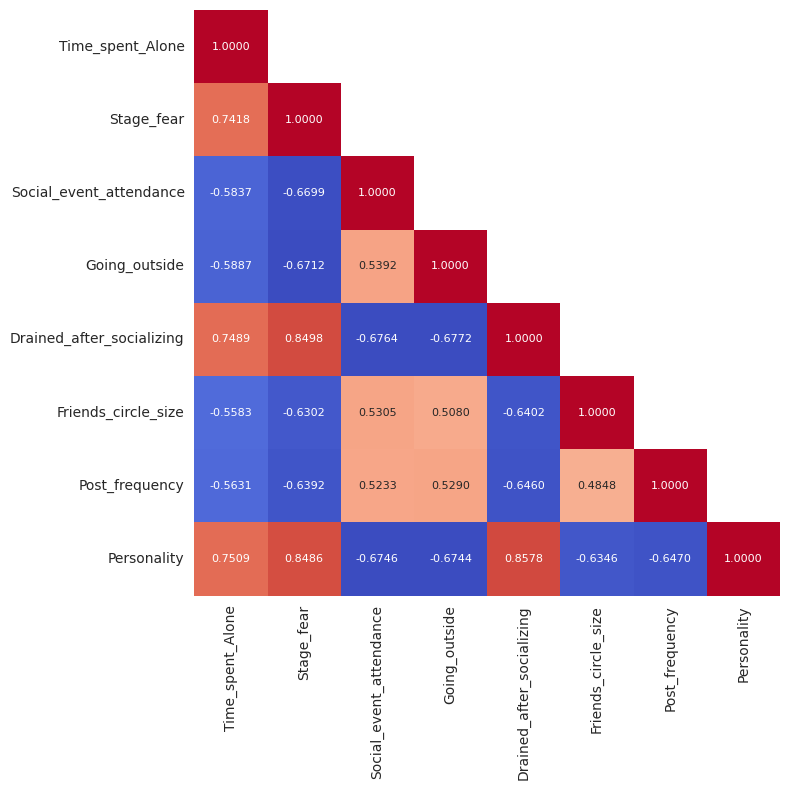

In [ ]:
sns.set_style('white')
plt.figure(figsize=(8,8))

corr_df_imputed = df_imputed.corr()
mask_df_imputed = np.triu(np.ones_like(corr_df_imputed, dtype=bool), k=1)

sns.heatmap(
    data=corr_df_imputed,
    annot=True,
    fmt='.4f',
    mask=mask_df_imputed,
    square=True,
    cmap='coolwarm',
    annot_kws={'size': 8},
    cbar=False
)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_regression

y = df_imputed['Personality']
X = df_imputed.drop('Personality', axis=1)

mutual_info = mutual_info_regression(X, y, random_state=42)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Drained_after_socializing,0.408063
Stage_fear,0.375886
Time_spent_Alone,0.354035
Social_event_attendance,0.336305
Post_frequency,0.326246
Going_outside,0.311164
Friends_circle_size,0.289309


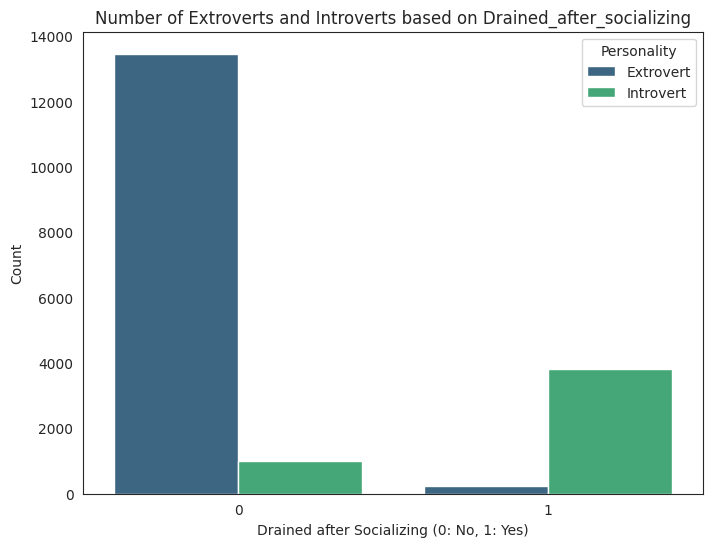

In [ ]:
df_imputed['Drained_after_socializing_rounded'] = df_imputed['Drained_after_socializing'].round().astype(int)

plt.figure(figsize=(8, 6))
sns.countplot(
    data=df_imputed,
    x='Drained_after_socializing_rounded',
    hue='Personality',
    palette='viridis'
)

plt.title('Number of Extroverts and Introverts based on Drained_after_socializing')
plt.xlabel('Drained after Socializing (0: No, 1: Yes)')
plt.ylabel('Count')

hues = {0: 'Extrovert', 1: 'Introvert'}
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=[hues[int(label)] for label in labels], title='Personality')

plt.show()


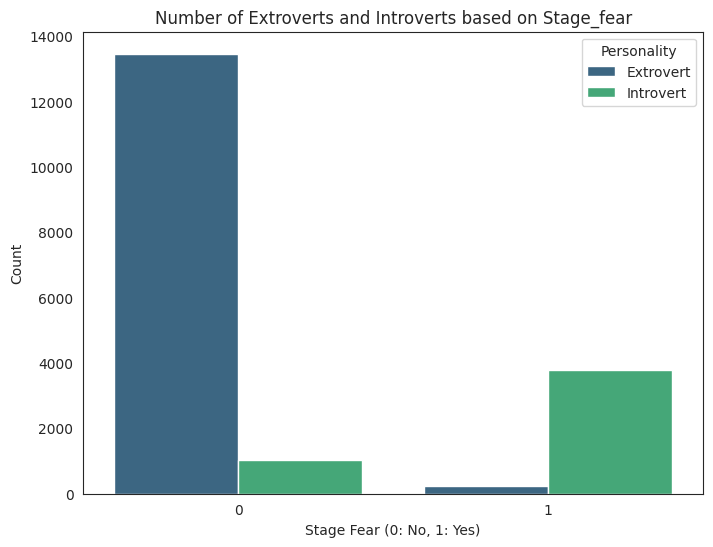

In [ ]:
df_imputed['Stage_fear_rounded'] = df_imputed['Stage_fear'].round().astype(int)


plt.figure(figsize=(8, 6))
sns.countplot(
    data=df_imputed,
    x='Stage_fear_rounded',
    hue='Personality',
    palette='viridis'
)


plt.title('Number of Extroverts and Introverts based on Stage_fear')
plt.xlabel('Stage Fear (0: No, 1: Yes)')
plt.ylabel('Count')


hues = {0: 'Extrovert', 1: 'Introvert'}
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=[hues[int(label)] for label in labels], title='Personality')

plt.show()

In [ ]:
df_imputed = df_imputed.drop(['Drained_after_socializing_rounded', 'Stage_fear_rounded'], axis=1)
df_imputed.columns

Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

## Model Training and Evaluation

This section outlines the process of training various classification models, combining them into an ensemble, and optimizing their hyperparameters.

1.  **Individual Models**: We utilized several powerful gradient boosting algorithms:
    *   **XGBoost (XGBClassifier)**
    *   **CatBoost (CatBoostClassifier)**
    *   **LightGBM (LGBMClassifier)**
    *   **HistGradientBoostingClassifier**

2.  **Ensemble Modeling**: A `VotingClassifier` with a 'soft' voting strategy was employed to combine the predictions of XGBoost, CatBoost, and LightGBM. This approach leverages the strengths of individual models to improve overall predictive performance.

3.  **Hyperparameter Tuning with Optuna**: Optuna was used to systematically search for the best hyperparameters for `HistGradientBoostingClassifier` and `LGBMClassifier`. The optimization objective was to maximize the accuracy score on a validation set.

4.  **Evaluation Metric**: Model performance was primarily evaluated using the **accuracy score**, which measures the proportion of correctly classified instances.

In [ ]:
xgb = XGBClassifier(
    max_depth=4,
    learning_rate=0.01,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

cat = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    class_weights=[1, 5], # handling imbalanced target values
    random_seed=42,
    verbose=0
)

lgbm = LGBMClassifier(
    num_leaves=31,
    learning_rate=0.1,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced', # handling imbalanced target values
    random_state=42
)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split

ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('cat', cat),
        ('lgbm', lgbm)
    ],
    voting='soft'
)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
ensemble.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constrai...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7f9328593ec0>),
                             ('lgbm',
                              LGBMClassifier(class_weight='balanced',
                                             colsample_bytree=0.8,
                                             n_estimators=300, random_state=42,
                                             subsample=0.8))],
                 voting='soft')

In [ ]:
# Optimize threshold
val_probs = ensemble.predict_proba(X_val)[:, 1]
best_threshold = 0.5
best_acc = 0

for threshold in np.arange(0.4, 0.6, 0.01):
    preds = (val_probs >= threshold).astype(int)

In [ ]:
test_probs = ensemble.predict_proba(X_val)[:, 1]
test_preds = (test_probs >= best_threshold).astype(int)

accuracy = accuracy_score(y_val, test_preds)
print(accuracy)

0.9713900134952766


In [ ]:
cb_params = {
    "border_count": 20, # discretizing numerical features into bins, which CatBoost then treats as categorical
    "colsample_bylevel": 0.25, # % considered for a split
    "depth": 5,
    "iterations": 1500,
    "l2_leaf_reg": 20,
    "learning_rate": 0.05,
    "min_child_samples": 160, # to make a split
    "random_state": 42,
    "random_strength": 0.7, # controls the degree of randomness introduced in score calculation for splits, higher number can help escape a local optima
    "scale_pos_weight": 1.5, # how many times more will the model weight underrepresented values in an imbalanced dataset
    "subsample": 0.2, # defines the fraction of data samples to be randomly sampled (without replacement) for building each tree, which helps to reduce variance
    "verbose": False,
    "cat_features": ["Stage_fear", "Drained_after_socializing"] # specified to be handled more efficiently
}

xgb_params = {
    "colsample_bylevel": 0.8168489864941239, # specifies the subsample ratio of columns for each level, the % that will be randomly sampled and considered for splitting
    "colsample_bynode": 0.8850485490950061, # % of features that will be randomly sampled for consideration at each node
    "colsample_bytree": 0.8379339940113913, # % of the total features are randomly sampled once for each tree's construction
    "gamma": 1.8, # specifies the minimum loss reduction required to make a further partition on a leaf node of the tree
    "learning_rate": 0.05,
    "max_depth": 244,
    "max_leaves": 69, # max number of terminal nodes in a tree
    "min_child_weight": 10, # defines the minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight (10), the building process stops further partitioning.
    "n_estimators": 696,
    "n_jobs": -1, # specifies the number of parallel threads used to run XGBoost. Setting it to -1 means to use all available processor cores, which can significantly speed up training.
    "random_state": 42,
    "reg_alpha": 1.849084818346014, # L1
    "reg_lambda": 29.680324563362227, # L2
    "subsample": 0.5902901569391961,
    "verbosity": 0,
    "enable_categorical": True
}

hgb_params = {
    "l2_regularization": 22,
    "learning_rate": 0.2,
    "max_depth": 325,
    "max_features": 0.24, # Proportion of randomly chosen features in each and every node split
    "max_iter": 2490,
    "max_leaf_nodes": 216,
    "min_samples_leaf": 12,
    "random_state": 42,
    "categorical_features": ["Stage_fear", "Drained_after_socializing"],
    "class_weight": "balanced"
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.55, # Subsample ratio of columns when constructing each tree
    "learning_rate": 0.03,
    "min_child_samples": 34,
    "min_child_weight": 0.3, # Minimum sum of instance weight (Hessian) needed in a child
    "n_estimators": 498,
    "n_jobs": -1,
    "num_leaves": 158,
    "random_state": 42,
    "reg_alpha": 5,
    "reg_lambda": 50,
    "subsample": 0.0011, # Subsample ratio of the training instance: % of the training data that will be randomly sampled (without replacement)
    "verbose": -1,
    "objective": "binary"
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.8384834064170148,
    "learning_rate": 0.07006829797238343,
    "min_child_samples": 46,
    "min_child_weight": 0.7625394962666617,
    "n_estimators": 1887,
    "n_jobs": -1,
    "num_leaves": 341,
    "random_state": 42,
    "reg_alpha": 10.53082019937197,
    "reg_lambda": 67.44600065144685,
    "subsample": 0.4925008305336127,
    "verbose": -1
}

lgbm_dart_params = {
    "boosting_type": "dart",
    "colsample_bytree": 0.7592971191793424,
    "learning_rate": 0.046141766106846074,
    "min_child_samples": 18,
    "min_child_weight": 0.4740109054323218,
    "n_estimators": 4035,
    "n_jobs": -1,
    "num_leaves": 393,
    "random_state": 42,
    "reg_alpha": 48.016799341666605,
    "reg_lambda": 89.12860300833658,
    "subsample": 0.016333358901112538,
    "verbose": -1
}

In [ ]:
set_seed=42

df['Personality'] = df['Personality'].map({'Extrovert': 0, 'Introvert': 1})
y_train = df['Personality']
X_train = df.drop('Personality', axis=1)
X_train_original, X_val_original, y_train_original, y_val_original = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

hgb_classifier = HistGradientBoostingClassifier(**hgb_params)
hgb_classifier.fit(X_train_original, y_train_original)

# hgb_classifier.get_params()

HistGradientBoostingClassifier(categorical_features=['Stage_fear',
                                                     'Drained_after_socializing'],
                               class_weight='balanced', l2_regularization=22,
                               learning_rate=0.2, max_depth=325,
                               max_features=0.24, max_iter=2490,
                               max_leaf_nodes=216, min_samples_leaf=12,
                               random_state=42)

In [ ]:
hgb_prediction = hgb_classifier.predict(X_val_original)

accuracy_hgb = accuracy_score(y_val_original, hgb_prediction)
print("Accuracy score for HGB: " ,accuracy_hgb)

Accuracy score for HGB:  0.9679740913997841


In [ ]:
X_train_original['Drained_after_socializing'] = X_train_original['Drained_after_socializing'].map({'No': 0, 'Yes': 1})
X_train_original['Stage_fear'] = X_train_original['Stage_fear'].map({'No': 0, 'Yes': 1})

X_val_original['Drained_after_socializing'] = X_val_original['Drained_after_socializing'].map({'No': 0, 'Yes': 1})
X_val_original['Stage_fear'] = X_val_original['Stage_fear'].map({'No': 0, 'Yes': 1})

lgbm_classifier = LGBMClassifier(**lgbm_params)
lgbm_classifier.fit(X_train_original, y_train_original)

lgbm_prediction = lgbm_classifier.predict(X_val_original)

accuracy_lgbm = accuracy_score(y_val_original, lgbm_prediction)
print("Accuracy score for LGBM: " ,accuracy_lgbm)

Accuracy score for LGBM:  0.9677941705649514


In [ ]:
X_train_original['Drained_after_socializing'] = X_train_original['Drained_after_socializing'].map({'No': 0, 'Yes': 1})
X_train_original['Stage_fear'] = X_train_original['Stage_fear'].map({'No': 0, 'Yes': 1})

X_val_original['Drained_after_socializing'] = X_val_original['Drained_after_socializing'].map({'No': 0, 'Yes': 1})
X_val_original['Stage_fear'] = X_val_original['Stage_fear'].map({'No': 0, 'Yes': 1})

In [ ]:

def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    regressor_name = trial.suggest_categorical('classifier', ['hgb', 'lgbm'])
    if regressor_name == 'hgb':
        l2_regularization = trial.suggest_float('l2_regularization', 10, 30)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)
        max_depth = trial.suggest_int('max_depth', 250, 350)
        max_features = trial.suggest_float('max_features', 0.15, 0.3)
        max_iter = trial.suggest_int('max_iter', 2000, 2600)
        max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 200, 250)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 10, 30)

        regressor_obj = HistGradientBoostingClassifier(
            l2_regularization= l2_regularization,
            learning_rate= learning_rate,
            max_depth= max_depth,
            max_features= max_features,
            max_iter= max_iter,
            max_leaf_nodes= max_leaf_nodes,
            min_samples_leaf= min_samples_leaf,
            random_state= 42,
            categorical_features= ["Stage_fear", "Drained_after_socializing"],
            class_weight= "balanced",
        )
    else:
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 0.75)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.07)
        min_child_samples = trial.suggest_int('min_child_samples', 27, 37)
        min_child_weight = trial.suggest_float('min_child_weight', 0.23, 0.32)
        n_estimators = trial.suggest_int('n_estimators', 400, 500)
        num_leaves = trial.suggest_int('num_leaves', 140, 165)
        reg_alpha = trial.suggest_float('reg_alpha', 4, 5.5)
        reg_lambda = trial.suggest_float('reg_lambda', 35, 60)
        subsample = trial.suggest_float('subsample', 0.001, 0.01)
        regressor_obj = LGBMClassifier(
            boosting_type= "gbdt",
            colsample_bytree= colsample_bytree,
            learning_rate= learning_rate,
            min_child_samples= min_child_samples,
            min_child_weight= min_child_weight,
            n_estimators= n_estimators,
            n_jobs= -1,
            num_leaves= num_leaves,
            random_state= 42,
            reg_alpha= reg_alpha,
            reg_lambda= reg_lambda,
            subsample= subsample,
            verbose= -1,
            objective= "binary",
        )

    regressor_obj.fit(X_train_original, y_train_original)
    y_pred = regressor_obj.predict(X_val_original)

    accuracy = accuracy_score(y_val_original, y_pred)

    return accuracy

study = optuna.create_study()
study.optimize(objective, n_trials=75)

trial = study.best_trial

print("Accuracy: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2025-12-21 19:20:06,865] A new study created in memory with name: no-name-88061462-6582-4c1c-9ca6-d224938da760
[I 2025-12-21 19:20:09,245] Trial 0 finished with value: 0.9677941705649514 and parameters: {'classifier': 'lgbm', 'colsample_bytree': 0.5094900204070119, 'learning_rate': 0.054583239035947584, 'min_child_samples': 37, 'min_child_weight': 0.30782056754744863, 'n_estimators': 427, 'num_leaves': 157, 'reg_alpha': 4.266670496003843, 'reg_lambda': 59.625305158956635, 'subsample': 0.006797280459418706}. Best is trial 0 with value: 0.9677941705649514.
[I 2025-12-21 19:20:10,764] Trial 1 finished with value: 0.9676142497301188 and parameters: {'classifier': 'lgbm', 'colsample_bytree': 0.5779213840513608, 'learning_rate': 0.06577722968150608, 'min_child_samples': 32, 'min_child_weight': 0.2833890302726643, 'n_estimators': 470, 'num_leaves': 141, 'reg_alpha': 4.53390423716826, 'reg_lambda': 53.432525855938614, 'subsample': 0.00499826461390384}. Best is trial 1 with value: 0.96761424

Accuracy: 0.9676142497301188
Best hyperparameters: {'classifier': 'lgbm', 'colsample_bytree': 0.5779213840513608, 'learning_rate': 0.06577722968150608, 'min_child_samples': 32, 'min_child_weight': 0.2833890302726643, 'n_estimators': 470, 'num_leaves': 141, 'reg_alpha': 4.53390423716826, 'reg_lambda': 53.432525855938614, 'subsample': 0.00499826461390384}


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

## Gradio Interface

This section describes the interactive web interface built using Gradio, allowing users to get personality predictions in real-time.

1.  **`predict_personality` Function**: This function serves as the backend for the Gradio interface. It takes seven input parameters representing the behavioral and social attributes:
    *   `time_spent_alone`: Hours spent alone per day.
    *   `stage_fear`: Whether the individual experiences stage fear (Yes/No).
    *   `social_event_attendance`: Number of social events attended per week.
    *   `going_outside`: Number of days spent outside per week.
    *   `drained_after_socializing`: Whether the individual feels drained after socializing (Yes/No).
    *   `friends_circle_size`: The size of the individual's friends circle.
    *   `post_frequency`: Number of social media posts per week.

2.  **Preprocessing within the Function**: Inside `predict_personality`, the categorical inputs (`Stage_fear`, `Drained_after_socializing`) are mapped from 'No'/'Yes' to numerical 0/1, consistent with the training data preprocessing. All input features are then cast to the appropriate data types (int or float) as expected by the trained model.

3.  **Prediction**: The preprocessed input is passed to the `ensemble` model's `predict()` method to obtain the personality prediction (0 for Extrovert, 1 for Introvert).

4.  **Gradio Interface Setup**: A `gr.Interface` object is configured with:
    *   **`fn`**: Set to `predict_personality`.
    *   **`inputs`**: Defined using Gradio components such as `gr.Slider` for numerical inputs and `gr.Radio` for categorical inputs, each with appropriate labels, ranges, and steps. Each input component clearly corresponds to one of the features used in the model.
    *   **`outputs`**: A `gr.Textbox` is used to display the predicted personality type ('Extrovert' or 'Introvert').
    *   **`title` and `description`**: Provide context for the application.


In [ ]:
def predict_personality(time_spent_alone, stage_fear, social_event_attendance, going_outside, drained_after_socializing, friends_circle_size, post_frequency):
    # Create a DataFrame from the input features
    input_data = pd.DataFrame({
        'Time_spent_Alone': [time_spent_alone],
        'Stage_fear': [stage_fear],
        'Social_event_attendance': [social_event_attendance],
        'Going_outside': [going_outside],
        'Drained_after_socializing': [drained_after_socializing],
        'Friends_circle_size': [friends_circle_size],
        'Post_frequency': [post_frequency]
    })

    # Preprocess categorical features: convert 'Yes'/'No' to 1/0
    input_data['Stage_fear'] = input_data['Stage_fear'].map({'No': 0, 'Yes': 1})
    input_data['Drained_after_socializing'] = input_data['Drained_after_socializing'].map({'No': 0, 'Yes': 1})

    # Ensure all columns are numeric (as KNNImputer outputs floats for categorical, we need to cast them for consistency if not already int)
    # The model expects float or int. If the mapping creates floats, it's fine.
    # For this specific task, the problem statement says to convert to 0/1, implying int.
    # However, the knn_imputation function used during training returned int values.
    # Let's ensure the types match the training data's structure (float for numerical, int for preprocessed categorical).
    input_data['Stage_fear'] = input_data['Stage_fear'].astype(int)
    input_data['Drained_after_socializing'] = input_data['Drained_after_socializing'].astype(int)

    # Predict using the ensemble model
    prediction = ensemble.predict(input_data)[0]

    # Return the personality type string
    if prediction == 0:
        return 'Extrovert'
    else:
        return 'Introvert'

print("The 'predict_personality' function has been defined.")

The 'predict_personality' function has been defined.


In [ ]:
import gradio as gr

# Define the Gradio interface
interface = gr.Interface(
    fn=predict_personality,
    inputs=[
        gr.Slider(minimum=0, maximum=12, step=1, label='Time spent Alone (hours per day)'),
        gr.Radio(['No', 'Yes'], label='Stage fear'),
        gr.Slider(minimum=0, maximum=7, step=1, label='Social event attendance (events per week)'),
        gr.Slider(minimum=0, maximum=7, step=1, label='Going outside (days per week)'),
        gr.Radio(['No', 'Yes'], label='Drained after socializing'),
        gr.Slider(minimum=0, maximum=20, step=1, label='Friends circle size'),
        gr.Slider(minimum=0, maximum=10, step=1, label='Post frequency (posts per week)')
    ],
    outputs=gr.Textbox(label='Predicted Personality'),
    title='Personality Predictor (Extrovert/Introvert)',
    description='Enter the following details to predict whether you are an Extrovert or an Introvert.'
)

# Launch the interface
interface.launch(debug=True)
